In [12]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# pwd

'/content/drive/My Drive/yolov7'

In [3]:
# cd drive

/content/drive


In [4]:
# ls

MyDrive/


In [5]:
# cd MyDrive

/content/drive/MyDrive


In [6]:
# ls


 2221CS09_Aditi.jpg
'Aadhar Mayank.pdf'
'AI Programming Tools'/
 ANN/
'Artificial Intelligence , Lisp and Prolog Complete'/
 Classroom/
'Colab Notebooks'/
'CS-210 Lab Marks .gsheet'
 darknet/
'Digital image processing'/
'Evolutionary computing'/
'Fuzzy Logic'/
'Hostel Allotment Letter.pdf'
 Imp/
'Knowledge Engineering and Expert Systems'/
 market1501-1/
 Mayank1.jpg
'Mayank_digi cam'/
 Mayank_Documents/
'Medical Insurance-Mayank Sah.pdf'
'Minor Project'/
 Papers/
'PhD Course Work.pdf'
 R.C.pdf
 Semester4/
 Tickets/
'Timothy ross.pdf'
 yolov7/


In [7]:
# !git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.94 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (521/521), done.
Updating files: 100% (104/104), done.


In [8]:
# ls

 2221CS09_Aditi.jpg
'Aadhar Mayank.pdf'
'AI Programming Tools'/
 ANN/
'Artificial Intelligence , Lisp and Prolog Complete'/
 Classroom/
'Colab Notebooks'/
'CS-210 Lab Marks .gsheet'
 darknet/
'Digital image processing'/
'Evolutionary computing'/
'Fuzzy Logic'/
'Hostel Allotment Letter.pdf'
 Imp/
'Knowledge Engineering and Expert Systems'/
 market1501-1/
 Mayank1.jpg
'Mayank_digi cam'/
 Mayank_Documents/
'Medical Insurance-Mayank Sah.pdf'
'Minor Project'/
 Papers/
'PhD Course Work.pdf'
 R.C.pdf
 Semester4/
 Tickets/
'Timothy ross.pdf'
 yolov7/


In [7]:
# cd yolov7

/content/drive/MyDrive/yolov7


In [6]:
# pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.6 MB/s eta 0:00:00


In [8]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [18]:
# pwd

'/content/drive/MyDrive/yolov7/Road_Sign_Dataset'

In [20]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [21]:
print(extract_info_from_xml('annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [22]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"trafficlight": 0,
                           "stop": 1,
                           "speedlimit": 2,
                           "crosswalk": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("annotations", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))


In [23]:
# Get the annotations
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

100%|██████████| 877/877 [00:11<00:00, 78.17it/s] 


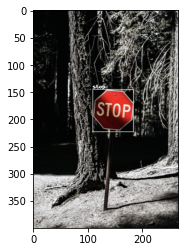

In [24]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


In [25]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('annotations', x) for x in os.listdir('annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)


In [9]:
pwd

'/content/drive/MyDrive/yolov7'

In [27]:
# cd images

/content/drive/MyDrive/yolov7/Road_Sign_Dataset/images


In [28]:
# mkdir train

In [29]:
# mkdir test

In [30]:
# mkdir val

In [31]:
# cd ..

/content/drive/MyDrive/yolov7/Road_Sign_Dataset


In [32]:
# ls

annotations/  images/


In [33]:
# mkdir labels

In [34]:
# ls

annotations/  images/  labels/


In [35]:
# cd labels

/content/drive/MyDrive/yolov7/Road_Sign_Dataset/labels


In [36]:
# mkdir train

In [37]:
# mkdir test

In [38]:
# mkdir val

In [39]:
# cd ..

/content/drive/MyDrive/yolov7/Road_Sign_Dataset


In [40]:
# ls

annotations/  images/  labels/


In [41]:
# pwd

'/content/drive/MyDrive/yolov7/Road_Sign_Dataset'

In [42]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')
!mv annotations labels
%cd ../

/content/drive/MyDrive/yolov7


In [43]:
# pwd

'/content/drive/MyDrive/yolov7'

In [15]:
!python train.py --img-size 640 --cfg cfg/training/yolov7.yaml --hyp data/hyp.scratch.custom.yaml --batch 8 --epochs 100 --data data/road_sign.yaml --weights '' --workers 24 --name yolo_road_det

YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(adam=False, artifact_alias='latest', batch_size=8, bbox_interval=-1, bucket='', cache_images=False, cfg='cfg/training/yolov7.yaml', data='data/road_sign.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.custom.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='yolo_road_det', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolo_road_det3', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=8, upload_dataset=False, v5_metric=False, weights='', workers=24, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2023-02-27 04:42:19.888637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary 

In [17]:
!python detect.py --source Road_Sign_Dataset/images/test/ --weights runs/train/yolo_road_det3/weights/best.pt --conf 0.25 --name yolo_road_det

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='yolo_road_det', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='Road_Sign_Dataset/images/test/', update=False, view_img=False, weights=['runs/train/yolo_road_det3/weights/best.pt'])
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15101.8125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36497954 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-model... 
 traced_script_modul

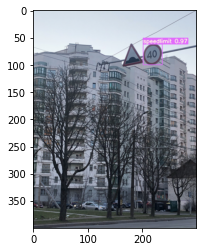

In [19]:
detections_dir = "runs/detect/yolo_road_det2/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))